# Pickle hyper parameters for static conflcit exposure

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import matplotlib as mpl    
mpl.rc('font',family='serif')

import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
np.random.seed(42)

import theano
import theano.tensor as tt
import pymc3 as pm

import pickle

import time

pm.__version__

/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


'3.6'

# Open train pickle:

In [2]:

pkl_file = open('train_df.pkl', 'rb')

df = pickle.load(pkl_file)

pkl_file.close()

In [3]:
df.shape

(442008, 10)

In [4]:
max_year = df['year'].max()
max_year

2012

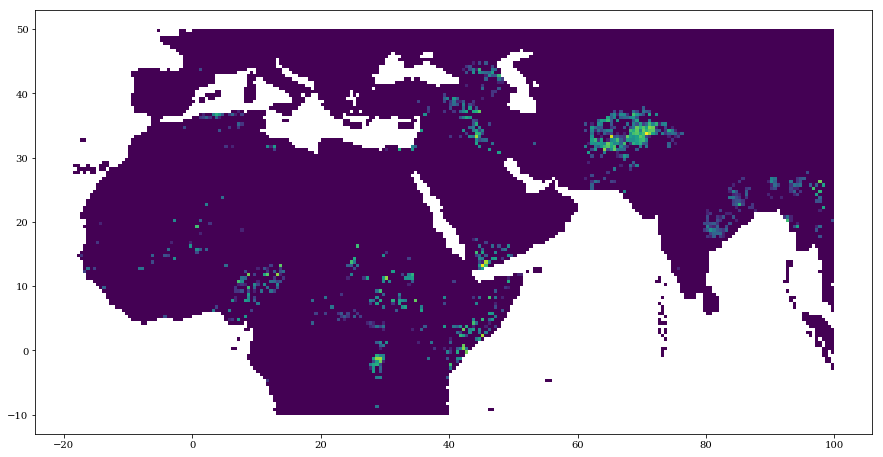

In [5]:
df[df['year']==max_year].plot(column = 'log_best', figsize=(15, 15))
plt.show()

# set X and y based on last observed year

In [6]:
df_my = df[df['year'] == max_year] 

X = np.array([df_my['xcoord'], df_my['ycoord']]).T
y = np.array(df_my['log_best'])

# for spares estimation:
df_non_zero = df_my[df_my['best']>0]
Xu = np.array([df_non_zero['xcoord'], df_non_zero['ycoord']]).T

# set hyper priors

In [7]:
# map = 15 mmin
# η_beta = 2
# ℓ_beta = 1
# ℓ_alpha = 5
# σ_beta = 5

# grid = np.linspace(0,15,1000)
# priors = [
#     ('$\eta$_prior', pm.HalfCauchy.dist(beta=η_beta)),
#     ('$\ell$_prior', pm.Gamma.dist(alpha=ℓ_alpha , beta=ℓ_beta )),
#     ('$\sigma$', pm.HalfCauchy.dist(beta=σ_beta))]

# plt.figure(figsize= [15,5])
# plt.title('Hyper-priors')


# for i, prior in enumerate(priors):
#     plt.plot(grid, np.exp(prior[1].logp(grid).eval()), label = prior[0])

# plt.xticks(np.arange(0,16,1))
# plt.xlim(0,15)
# plt.legend()
# plt.show()

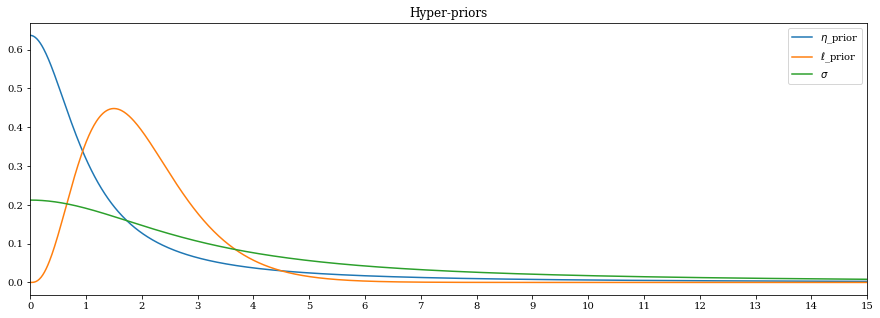

In [8]:
η_beta = 1
ℓ_beta = 2
ℓ_alpha = 4
σ_beta = 3

grid = np.linspace(0,15,1000)
priors = [
    ('$\eta$_prior', pm.HalfCauchy.dist(beta=η_beta)),
    ('$\ell$_prior', pm.Gamma.dist(alpha=ℓ_alpha , beta=ℓ_beta )),
    ('$\sigma$', pm.HalfCauchy.dist(beta=σ_beta))]

plt.figure(figsize= [15,5])
plt.title('Hyper-priors')


for i, prior in enumerate(priors):
    plt.plot(grid, np.exp(prior[1].logp(grid).eval()), label = prior[0])

plt.xticks(np.arange(0,16,1))
plt.xlim(0,15)
plt.legend()
plt.show()

# Estimation hyper parameters:

In [9]:
# time0 = time.time()

# with pm.Model() as model:
    
#     # priors
#     ℓ = pm.Gamma("ℓ", alpha=ℓ_alpha, beta=ℓ_beta, shape = 1)
#     η = pm.HalfCauchy("η", beta=η_beta, shape = 1)

#     # noise model
#     σ = pm.HalfCauchy("σ", beta=σ_beta, shape = 1)
        
#     cov = η **2 * pm.gp.cov.ExpQuad(2, ℓ)
        
#     gp = pm.gp.Marginal(cov_func=cov)
        
#     y_ = gp.marginal_likelihood("y_", X=X, y=y, noise= σ)

In [10]:
time0 = time.time()

with pm.Model() as model:
    
    # priors
    ℓ = pm.Gamma("ℓ", alpha=ℓ_alpha, beta=ℓ_beta, shape = 1)
    η = pm.HalfCauchy("η", beta=η_beta, shape = 1)

    # noise model
    σ = pm.HalfCauchy("σ", beta=σ_beta, shape = 1)
        
    cov = η **2 * pm.gp.cov.ExpQuad(2, ℓ)
        
    gp = pm.gp.MarginalSparse(cov_func=cov) # ved ikke om det gør en forskel til FICT
    y_ = gp.marginal_likelihood("y_", X=X, Xu = Xu, y=y, noise= σ)

In [11]:
time1 = time.time()

with model:
    mp = pm.find_MAP()

/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `ar

In [12]:
time2 = time.time()
step0t = (time1 - time0)/60
step1t = (time2 - time1)/60

stepallt = (time2 - time0)/60

print('step 0: {}min \n step 1: {} \n time total: {}min'.format(step0t, step1t, stepallt))

step 0: 0.3515745480855306min 
 step 1: 16.423123451073966 
 time total: 16.774697999159496min


In [13]:
mp

{'η': array([0.19606605]),
 'η_log__': array([-1.62930369]),
 'σ': array([0.47970503]),
 'σ_log__': array([-0.73458388]),
 'ℓ': array([1.32328046]),
 'ℓ_log__': array([0.28011385])}

In [15]:

time1 = time.time()

with model:
    trace = pm.sample() # 20 samples på 10 min...
#     trace = pm.sample(1000, tune=1000, chains=2, cores=2, nuts_kwargs={"target_accept":0.95}) # 9 in 4.5 min
    
time1 = time.time()
stepallt = (time1 - time0)/60
print('time total: {}min'.format(stepallt))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, η, ℓ]
Sampling 4 chains: 100%|██████████| 4000/4000 [270:43:37<00:00, 336.34s/draws]
The acceptance p

time total: 16279.7963920633min


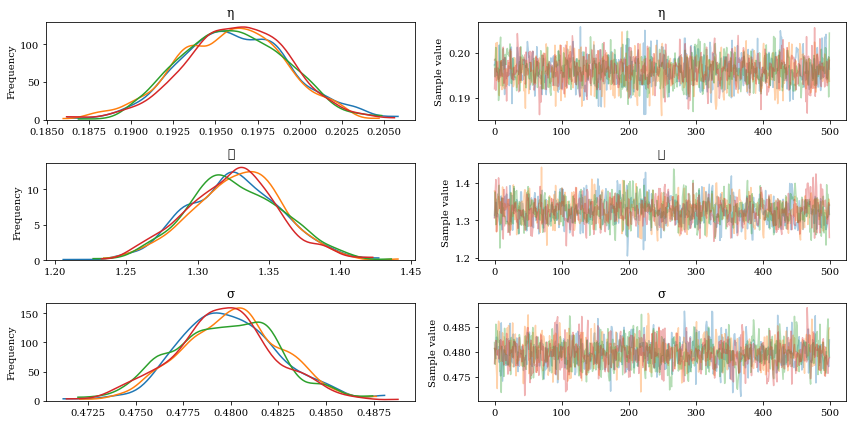

In [16]:
pm.traceplot(trace, varnames=['η', 'ℓ', 'σ'])
plt.show()

In [17]:
file_name = "spatial_trace.pkl"
output = open(file_name, 'wb') 
pickle.dump(trace, output)
output.close()

In [18]:
file_name = "spatial_map.pkl"
output = open(file_name, 'wb')
pickle.dump(mp, output)
output.close()

In [27]:
pm.summary(trace, varnames=['η', 'ℓ', 'σ'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
η__0,0.196058,0.003135,0.000073,0.190021,0.202092,1849.025188,1.000839
ℓ__0,1.325628,0.032640,0.000918,1.261821,1.389521,1373.703987,1.000468
σ__0,0.479795,0.002674,0.000066,0.474506,0.484968,1630.980252,1.002241


In [25]:
print(np.mean(trace.get_values('η')))
print(np.mean(trace.get_values('ℓ')))
print(np.mean(trace.get_values('σ')))

0.196058340963208
1.3256282151267167
0.47979509065146325


In [28]:
file_name = "spatial_eta.pkl"
output = open(file_name, 'wb') 
pickle.dump(trace.get_values('η'), output)
output.close()

In [29]:
file_name = "spatial_ell.pkl"
output = open(file_name, 'wb') 
pickle.dump(trace.get_values('ℓ'), output)
output.close()

In [30]:
file_name = "spatial_sigma.pkl"
output = open(file_name, 'wb') 
pickle.dump(trace.get_values('σ'), output)
output.close()

# Pickle test:

In [31]:
pkl_file = open('spatial_trace.pkl', 'rb')

pickle_test_trace = pickle.load(pkl_file)

pkl_file.close()

In [32]:
pm.summary(pickle_test_trace, varnames=['η', 'ℓ', 'σ'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
η__0,0.196058,0.003135,0.000073,0.190021,0.202092,1849.025188,1.000839
ℓ__0,1.325628,0.032640,0.000918,1.261821,1.389521,1373.703987,1.000468
σ__0,0.479795,0.002674,0.000066,0.474506,0.484968,1630.980252,1.002241


In [33]:
pkl_file = open('spatial_eta.pkl', 'rb')

pickle_test_eta = pickle.load(pkl_file)

pkl_file.close()

print(np.mean(pickle_test_eta))

0.196058340963208


In [34]:
pkl_file = open('spatial_ell.pkl', 'rb')

pickle_test_ell = pickle.load(pkl_file)

pkl_file.close()

print(np.mean(pickle_test_ell))

1.3256282151267167


In [35]:
pkl_file = open('spatial_sigma.pkl', 'rb')

pickle_test_sigma = pickle.load(pkl_file)

pkl_file.close()

print(np.mean(pickle_test_sigma))

0.47979509065146325
